# **Определение закономерностей успешных игр для интернет-магазина «Стримчик».**

**Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы и мы планируем кампанию на 2017-й.**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st

## Изучение общей информации.

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


**Датасет необходимо обработать для дальнейшей удобной работы с данными. Для этого нужно будет привести названия столбцов к нижнеу регистру, убрать пропуски в столбцах `Critic_Score`, `User_Score`, `Rating`при помощи "заглушек", изменить типы значений в столбцах `Year_of_Release` и `User_Score`.**

## Предобработка данных.

**Приведем названия столбцов к нижнему регистру.**

In [3]:
data.columns = data.columns.str.lower()

**Чтобы преобразовать данные в столбце `year_of_release` в целочисленные, применим метод `astype('Int64')`.**

In [4]:
data['year_of_release'] = data['year_of_release'].astype('Int64')
data.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


**В столбце `genre` пропущено 2 значения. Найдем их:**

In [5]:
data[data['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


**2 игрушки на платформе SegaGenesis без имени, без жанра, без вкуса, без цвета и запаха. Удалим эти строчки, заодно избавимся от пропусков в столбце `name`. Удалим строки с пропущенными значениями в столбце `year_of_release`. Восстановить мы их не сможем, их немного, всего 269 пропусков(1,6% от всего датасета), они не будут нам мешаться и после удаления не испортят общей картины.**

In [6]:
data = data.dropna(subset=['genre','year_of_release'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


**Остались пропуски в оценках критиков и пользователей, а также в столбце рейтинг. Посмотрим, что там:**

In [7]:
data[data['rating'].isna()].sort_values(by ='year_of_release', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16714,Winning Post 8 2016,PSV,2016,Simulation,0.00,0.00,0.01,0.00,NaN,NaN,NaN
5898,Dragon Quest Builders: Revive Alefgard,PSV,2016,Role-Playing,0.00,0.00,0.30,0.00,NaN,NaN,NaN
13232,Resident Evil 4 HD,PS4,2016,Shooter,0.04,0.00,0.00,0.01,NaN,NaN,NaN
13224,Ghostbusters (2016),XOne,2016,Action,0.04,0.00,0.00,0.01,NaN,NaN,NaN
6085,Dragon Quest Heroes II: Twin Kings and the Pro...,PS4,2016,Action,0.00,0.00,0.28,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
6875,Checkers,2600,1980,Misc,0.22,0.01,0.00,0.00,NaN,NaN,NaN
4019,Ice Hockey,2600,1980,Sports,0.46,0.03,0.00,0.01,NaN,NaN,NaN
262,Asteroids,2600,1980,Shooter,4.00,0.26,0.00,0.05,NaN,NaN,NaN
546,Missile Command,2600,1980,Shooter,2.56,0.17,0.00,0.03,NaN,NaN,NaN


**ESRB была основана в 1994 году. Получается, что рейтинг получили продукты, вышедшие после основания ESRB. Кроме этого деятельность ESRB официально ограничена Канадой, США и Мексикой. Игры, вышедшие в других регионах, не имеют оценки данной организации.**

**Как видно, оценка пользователей не затронула более 6700 игр. Видно, что эти игры плохо продавались, скорее всего не рекламировались и внимание игроков прошло стороной эти игры. Отметим отсутствие рейтинга пользователей и критиков значением `-1`. Пропуски в столбце `rating` заполним значением `Unrated`.**

In [8]:
data['user_score'] = data['user_score'].fillna((-1))
data['critic_score'] = data['critic_score'].fillna((-1))
data['rating'] = data['rating'].fillna('Unrated')

**Посчитаем глобальные продажи и добавим значения в новый столбец.**

In [9]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1,Unrated,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1,Unrated,31.38


In [10]:
data['user_score'].value_counts()

-1     6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
0.9       2
1.3       2
1.5       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64

**Стоит отметить, что 2376 игр имеют оценку tbd. Рейтинг Tbd игр — это оценка, которую дают играм, когда у них нет достаточного количества отзывов или оценок для определения конкретного рейтинга. Термин «Tbd» расшифровывается как «To Be Determined» и означает, что окончательный рейтинг игры будет определен позднее.**

In [11]:
data[data['user_score'] == 'tbd'].sort_values(by ='total_sales', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,-1.0,tbd,E,6.70
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+,3.97
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,-1.0,tbd,T,2.81
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E,2.42
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,-1.0,tbd,E,2.24
...,...,...,...,...,...,...,...,...,...,...,...,...
15983,Mission: Impossible - Operation Surma,GC,2004,Platform,0.01,0.00,0.0,0.00,64.0,tbd,T,0.01
15979,Monster Trux Offroad,Wii,2007,Racing,0.01,0.00,0.0,0.00,-1.0,tbd,E,0.01
15975,Paranormal Pursuit: The Gifted One,PC,2015,Action,0.00,0.01,0.0,0.00,-1.0,tbd,Unrated,0.01
15963,Dead to Rights,GBA,2004,Shooter,0.01,0.00,0.0,0.00,40.0,tbd,T,0.01


**Снова непопулярные игры, достаточного количества отзавов пользователей они врят ли уже наберут. Будем считать, что пользователи не стали их оценивать и рейтинг так и остался равен нулю. Заменим значения `tbd` на `-1`.**

In [12]:
data['user_score'] = data['user_score'].where(data['user_score'] != 'tbd', (-1))
data['user_score'].value_counts()
data['user_score'] = data['user_score'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


In [13]:
data.duplicated().sum()

0

**Явных дубликатов нет. Сделаем проверку на наличие неявных дубликатов.**

In [14]:
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E,0.01


In [15]:
data = data.drop(index = 16230)
data[data.duplicated(['name', 'platform', 'year_of_release'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales


**Проведена предобработка данных: были привести названия столбцов к нижнеу регистру, убраны пропуски в столбцах `Critic_Score`, `User_Score`, `Rating`при помощи "заглушек", изменены типы значений в столбцах `Year_of_Release` и `User_Score`, проверен датасет на наличие дубликатов. Явных дубликатов не обнаружено, но нашелся 1 неявный дубликат, мы от него избавились. Таблица готова к проведению исследовательского анализа.**

## Шаг 3. Проведем исследовательский анализ данных.

Text(0.5, 1.0, 'Количество игр, выпускаемых каждый год')

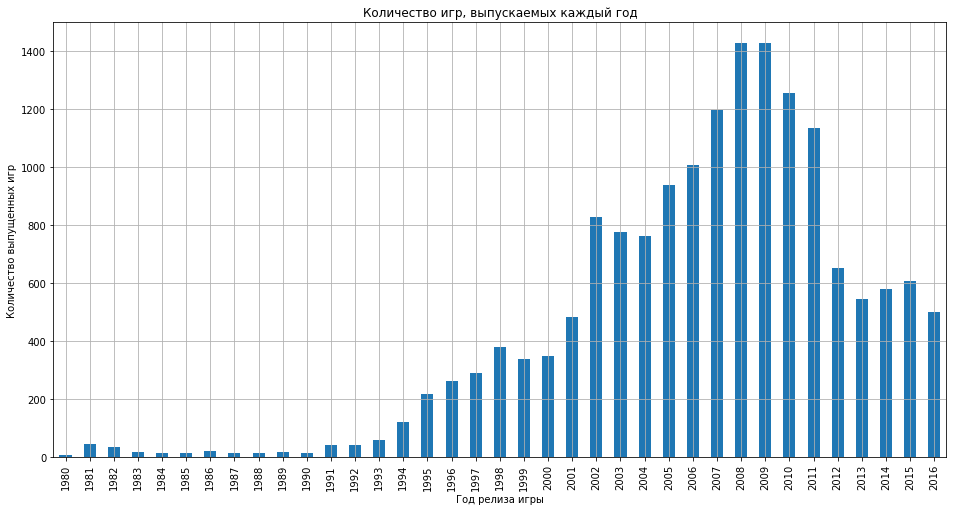

In [16]:
game_each_year =(
    data
    .pivot_table(index='year_of_release', 
                 values='name', 
                 aggfunc='count')
    .reset_index()
    .plot(x='year_of_release', y='name', kind='bar', grid=True, figsize=(16,8), legend=False)
)
plt.ylabel('Количество выпущенных игр')
plt.xlabel('Год релиза игры')
plt.title('Количество игр, выпускаемых каждый год')

**Определим продолжительность жизни платформ.**

  platform  total_sales  year_of_release
0      PS2      1233.56               12
1     X360       961.24               12
2      PS3       931.33               11
3      Wii       891.18               11
4       DS       802.78               11
5       PS       727.58               10
6      PS4       314.14                4
7      GBA       312.88                8
8      PSP       289.53               12
9      3DS       257.81                6
Средняя продолжительность жизни у топ-10 самых прибыльных платформ за весь период: 9.7


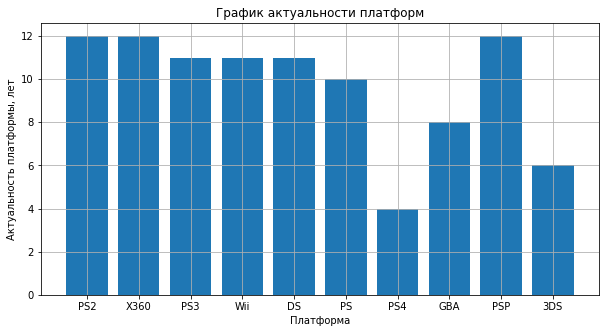

In [17]:
duration_pl =(
    data
    .pivot_table(index=['platform', 'year_of_release'], 
                 values=['total_sales'], 
                 aggfunc={'total_sales':'sum'})
    .reset_index()
    .sort_values(by='total_sales', ascending=False)
    .pivot_table(index='platform', values=['year_of_release', 'total_sales'], aggfunc={'year_of_release':'count', 'total_sales':'sum'})
    .sort_values(by='total_sales', ascending=False).head(10)
    .reset_index() 
)
plt.figure(figsize=(10,5))
plt.bar(duration_pl['platform'], duration_pl['year_of_release'])
plt.ylabel('Актуальность платформы, лет')
plt.xlabel('Платформа')
plt.title('График актуальности платформ')
plt.grid()
print(duration_pl)
print('Средняя продолжительность жизни у топ-10 самых прибыльных платформ за весь период:', duration_pl['year_of_release'].mean())

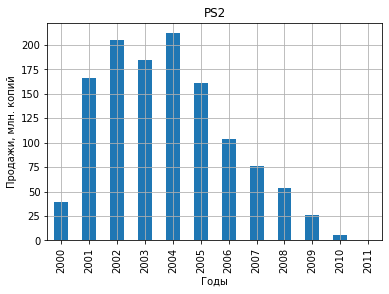

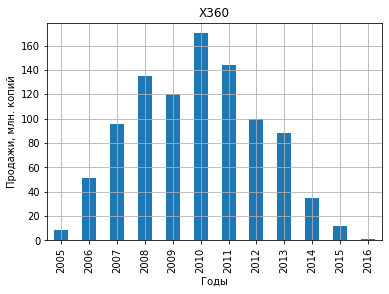

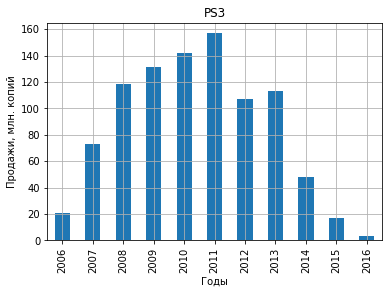

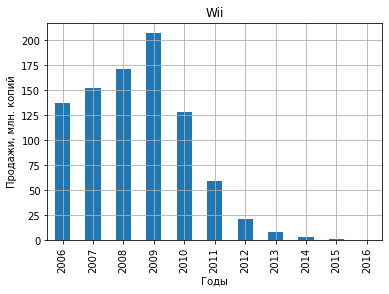

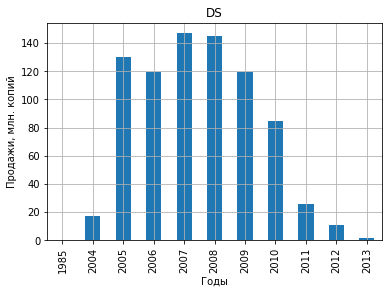

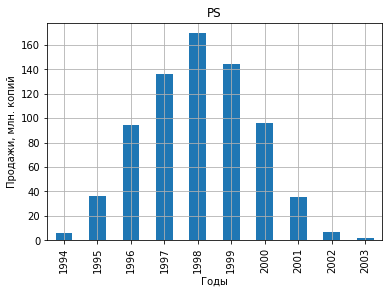

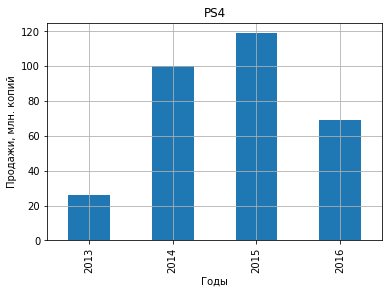

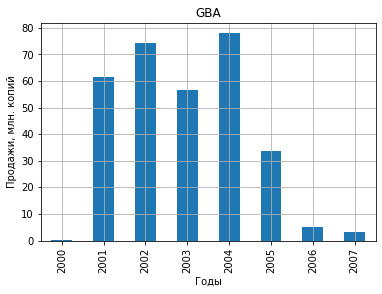

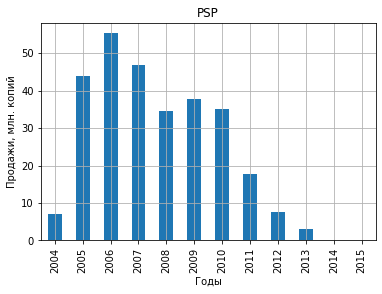

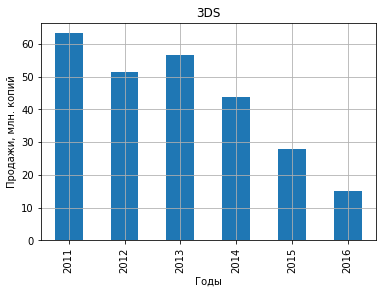

In [18]:
for i in list(duration_pl['platform']):    
    (
        data[data['platform'] == i]
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .reset_index() 
        .sort_values(by='year_of_release')
        .plot(x='year_of_release', y='total_sales', kind='bar', grid=True, legend=False)
    )
    plt.xlabel('Годы')
    plt.ylabel('Продажи, млн. копий')
    plt.title(i)

**Построенные графики показывают, что начиная с 2000 года начинается резкий рост производства игр, вплоть до 2008, затем после 2009 идет такой же спад. Актуальный период для исследования возьмем более спокойный - с 2012 года. Что касается платформ, стоит отметить, что средний период актуальности платформы составляет, примерно, 10 лет.**

**Таблица с актуальными данными.**

In [19]:
current_data = data[data['year_of_release'] >= 2012]
current_data.info()
current_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2885 entries, 16 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2885 non-null   object 
 1   platform         2885 non-null   object 
 2   year_of_release  2885 non-null   Int64  
 3   genre            2885 non-null   object 
 4   na_sales         2885 non-null   float64
 5   eu_sales         2885 non-null   float64
 6   jp_sales         2885 non-null   float64
 7   other_sales      2885 non-null   float64
 8   critic_score     2885 non-null   float64
 9   user_score       2885 non-null   float64
 10  rating           2885 non-null   object 
 11  total_sales      2885 non-null   float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 295.8+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,Unrated,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,Unrated,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


**Определим топ-5 прибыльных платформ.**

Text(0.5, 1.0, 'Лучшие платформы по продажам')

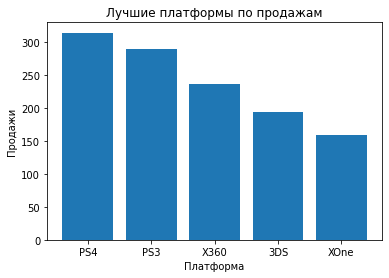

In [20]:
top_5_platforms =(
    current_data
    .pivot_table(index='platform', 
                 values='total_sales', 
                 aggfunc='sum')       
    .sort_values(by='total_sales', ascending=False).head() 
    .reset_index() 
)
plt.bar(top_5_platforms['platform'], top_5_platforms['total_sales'])
plt.xlabel('Платформа')
plt.ylabel('Продажи')
plt.title('Лучшие платформы по продажам')

**С 2012 года самыми популярными платформами среди пользователей были PS4, РS3, X360, 3DS и XOne.**

In [21]:
top_5_platforms

,platform,total_sales
0,PS4,314.14
1,PS3,288.78
2,X360,236.54
3,3DS,194.61
4,XOne,159.32


**Посмотрим, как менялись продажи по этим платформам.**

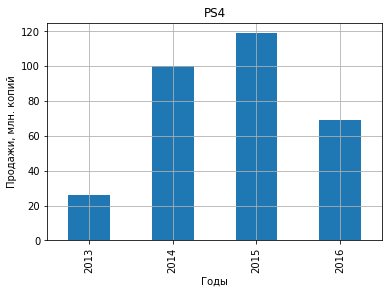

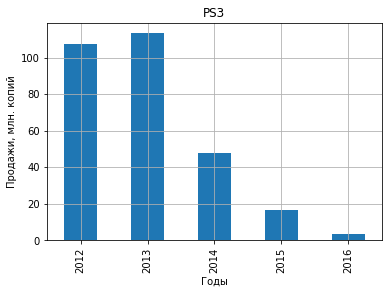

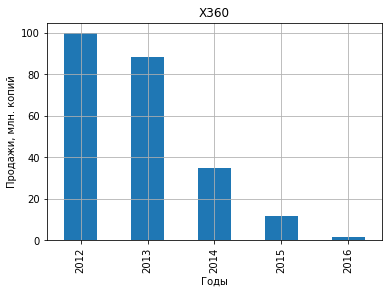

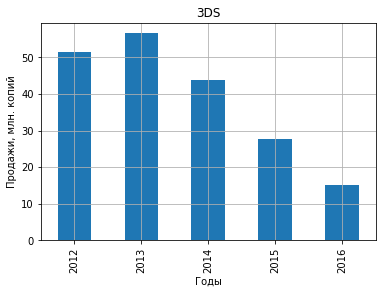

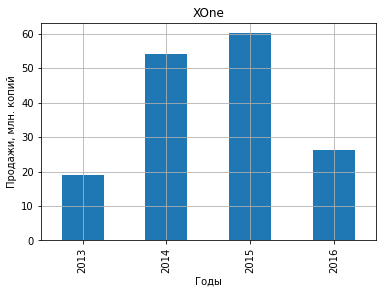

In [22]:
for i in list(top_5_platforms['platform']):    
    (
        current_data[current_data['platform'] == i]
        .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
        .reset_index() 
        .sort_values(by='year_of_release')
        .plot(x='year_of_release', y='total_sales', kind='bar', grid=True, legend=False)
    )
    plt.xlabel('Годы')
    plt.ylabel('Продажи, млн. копий')
    plt.title(i)

**Графики показывают общий спад объемов продаж у всех выбранных платформ в прошлом, 2015 году. Самый продолжительный спад наблюдается на платформе PC и на 3DS. К тому же у платформ Нинтендо и PC годовые выручки не превышают 10 млн. проданных копий, но консоли Нинтендо очень популярны в Японии. По совокупности фактов привлекательными для нас остаются только 3 платформы: PS4 и XOne для североамериканского и европейского регионов, а 3DS для Японии.**

**Строим ящик с усами по глобальным продажам игр в разбивке по платформам.**

(0.0, 2.0)

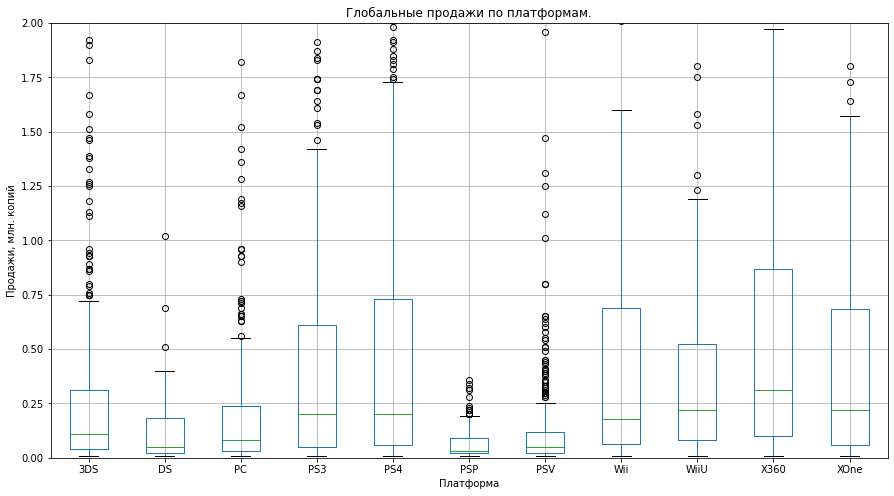

In [23]:
plt.figure(figsize=(15, 8))
(
    current_data
    .pivot_table(index='name', columns='platform', values='total_sales').boxplot()
)
plt.ylabel('Продажи, млн. копий')
plt.xlabel('Платформа')
plt.title('Глобальные продажи по платформам.')
plt.ylim(0, 2)

**Лучше всего себя чувствует платформа X360, следом идут платформы XOne, WiiU, Wii, PS3 и PS4. Платформы DS, PSP, PSV уже устарели и теряются на фоне новых конкурентов.**

**Определим связи между отзывами и продажами.**

Text(0.5, 1.0, 'График зависимости продаж от оценки пользователей')

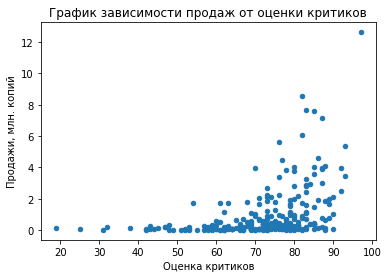

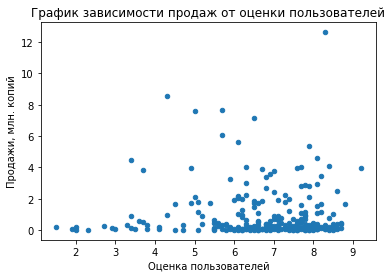

In [24]:
current_data[(current_data['platform'] == 'PS4')&(current_data['critic_score'] != -1)]\
.plot.scatter(x='critic_score', y='total_sales')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи, млн. копий')
plt.title('График зависимости продаж от оценки критиков')

current_data[(current_data['platform'] == 'PS4')&(current_data['user_score'] != -1)]\
.plot.scatter(x='user_score', y='total_sales')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи, млн. копий')
plt.title('График зависимости продаж от оценки пользователей')

In [25]:
current_data[(current_data['platform'] == 'PS4')&(current_data['critic_score'] != -1)&(current_data['user_score'] != -1)].corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.261760,-0.191355,-0.122830,-0.232177,-0.019983,0.150315,-0.234400
na_sales,-0.261760,1.000000,0.714988,0.530480,0.915292,0.414241,-0.022577,0.893807
eu_sales,-0.191355,0.714988,1.000000,0.519826,0.935136,0.346044,-0.050671,0.951656
jp_sales,-0.122830,0.530480,0.519826,1.000000,0.566734,0.322057,0.174512,0.592214
other_sales,-0.232177,0.915292,0.935136,0.566734,1.000000,0.408465,-0.037332,0.997798
critic_score,-0.019983,0.414241,0.346044,0.322057,0.408465,1.000000,0.557654,0.405895
user_score,0.150315,-0.022577,-0.050671,0.174512,-0.037332,0.557654,1.000000,-0.033625
total_sales,-0.234400,0.893807,0.951656,0.592214,0.997798,0.405895,-0.033625,1.000000


In [26]:
ps4 = current_data[(current_data['platform'] == 'PS4')&(current_data['critic_score'] != -1)]
ps4['total_sales'].corr(ps4['critic_score'])

0.406567902061781

Корреляция глобальных продаж от оценок критиков для платформы PS4 : 0.406567902061781
Корреляция глобальных продаж от оценок пользователей для платформы PS4 : 0.35040745878505786

Корреляция глобальных продаж от оценок критиков для платформы PS3 : 0.3341517575509856
Корреляция глобальных продаж от оценок пользователей для платформы PS3 : 0.2030919395706011

Корреляция глобальных продаж от оценок критиков для платформы X360 : 0.36057348885073365
Корреляция глобальных продаж от оценок пользователей для платформы X360 : 0.2545770149075233

Корреляция глобальных продаж от оценок критиков для платформы 3DS : 0.32080286953607845
Корреляция глобальных продаж от оценок пользователей для платформы 3DS : 0.2497895570163375

Корреляция глобальных продаж от оценок критиков для платформы XOne : 0.41699832800840175
Корреляция глобальных продаж от оценок пользователей для платформы XOne : 0.3335794430098834



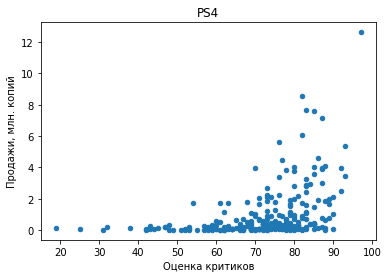

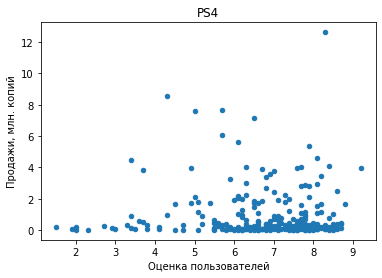

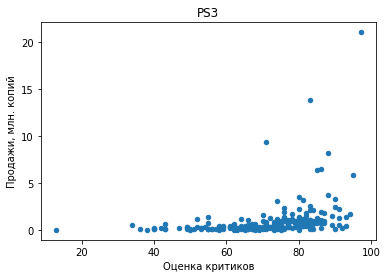

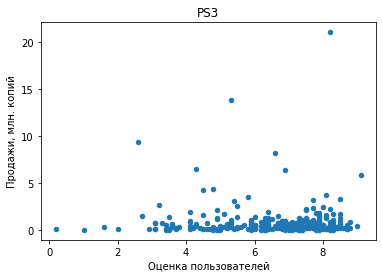

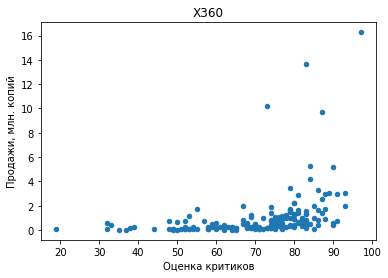

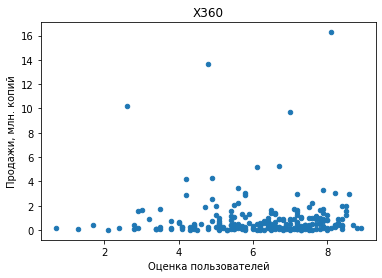

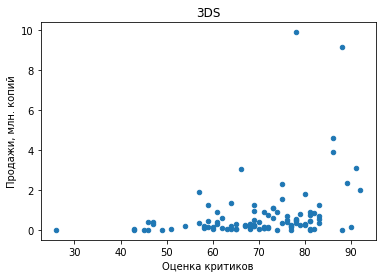

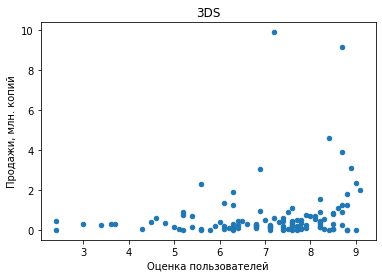

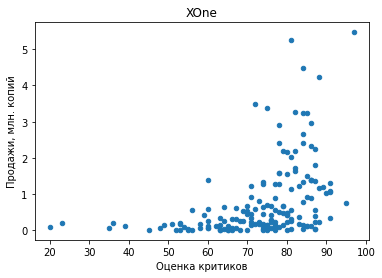

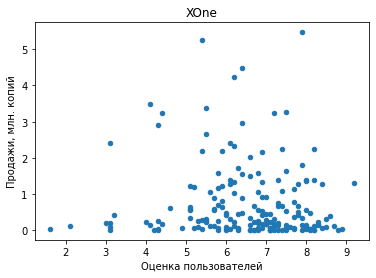

In [27]:
for i in list(top_5_platforms['platform']):
    for_corr_critics = current_data[(current_data['platform'] == i)&(current_data['critic_score'] != -1)]
    for_corr_critics.plot.scatter(x='critic_score', y='total_sales')
    plt.xlabel('Оценка критиков')
    plt.ylabel('Продажи, млн. копий')
    plt.title(i)
    print('Корреляция глобальных продаж от оценок критиков для платформы', i, ':', for_corr_critics['total_sales'].corr(for_corr_critics['critic_score']))
    
    for_corr_users = current_data[(current_data['platform'] == i)&(current_data['user_score'] != -1)]
    for_corr_users.plot.scatter(x='user_score', y='total_sales')
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи, млн. копий')
    plt.title(i)
    print('Корреляция глобальных продаж от оценок пользователей для платформы', i, ':', for_corr_users['total_sales'].corr(for_corr_users['critic_score']))
    print()    

**Связь между отзывами и продажами положительная слабовыраженная.**

**Распределим жанры по глобальным продажам.**

Text(0.5, 1.0, 'Глобальные продажи по каждому жанру.')

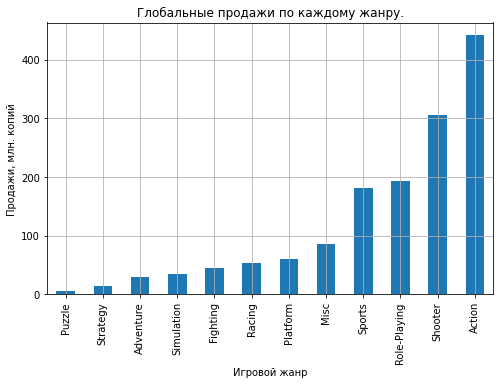

In [28]:
(
    current_data
    .pivot_table(index=['genre'], 
                 values=['name', 'total_sales'], 
                 aggfunc={'name':'count', 'total_sales':'sum'})
    .reset_index()
    .rename(columns={'name':'count_game'})
    .sort_values(by='total_sales')
    .plot(x='genre', y='total_sales', kind='bar', grid=True, figsize=(8,5), legend=False)
)
plt.ylabel('Продажи, млн. копий')
plt.xlabel('Игровой жанр')
plt.title('Глобальные продажи по каждому жанру.')

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по жанрам.**

(0.0, 15.0)

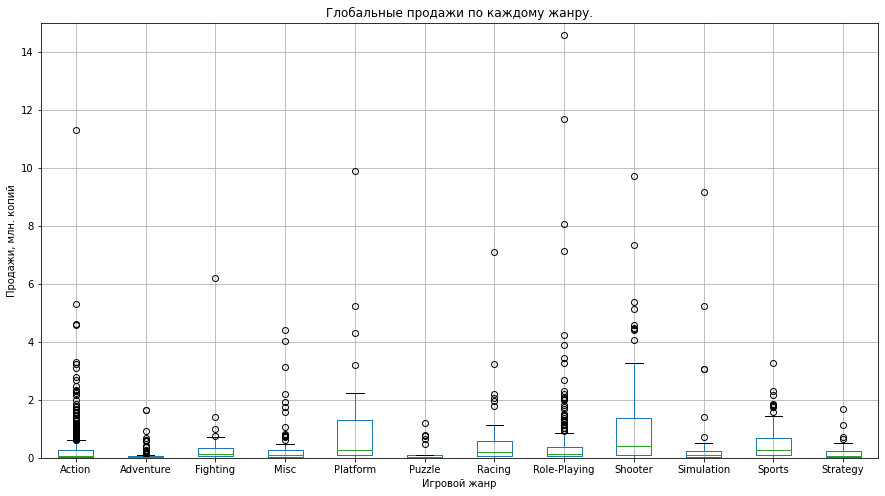

In [29]:
plt.figure(figsize=(15, 8))
(
    current_data
    .pivot_table(index='name', columns='genre', values='total_sales').boxplot()
)
plt.ylabel('Продажи, млн. копий')
plt.xlabel('Игровой жанр')
plt.title('Глобальные продажи по каждому жанру.')
plt.ylim(0, 15)

**Тот же самый плотбокс, только с уменьшенной границей по оси Продаж. Сделано для оценки медианных значений.**

(0.0, 3.3)

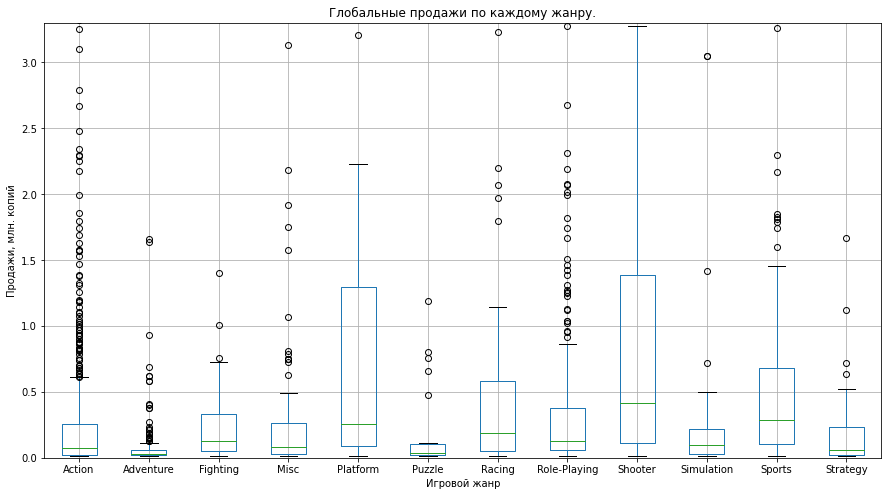

In [30]:
plt.figure(figsize=(15, 8))
(
    current_data
    .pivot_table(index='name', columns='genre', values='total_sales').boxplot()
)
plt.ylabel('Продажи, млн. копий')
plt.xlabel('Игровой жанр')
plt.title('Глобальные продажи по каждому жанру.')
plt.ylim(0, 3.3)

**Самыми продаваемыми жанрами являются `Action`, `Shooter`, `RPG` и `Sports`. Остальные жанры не выделяются большими объемами продаж, явно уступая лидерам. Что касается медианного значения продаж, то по всем платформам оно не превышает 500 тыс. копий по всему миру. Выходит, что объем продаж и выручки делают "хитовые игры". Больше всего такие игры встречаются как раз в указанных выше жанрах. Именно на хиты и нужно делать упор при планировании рекламной компании на следующий год.**

## Составление портрета пользователя каждого региона.

Text(0.5, 0.98, 'Рейтинг платформ в регионах')

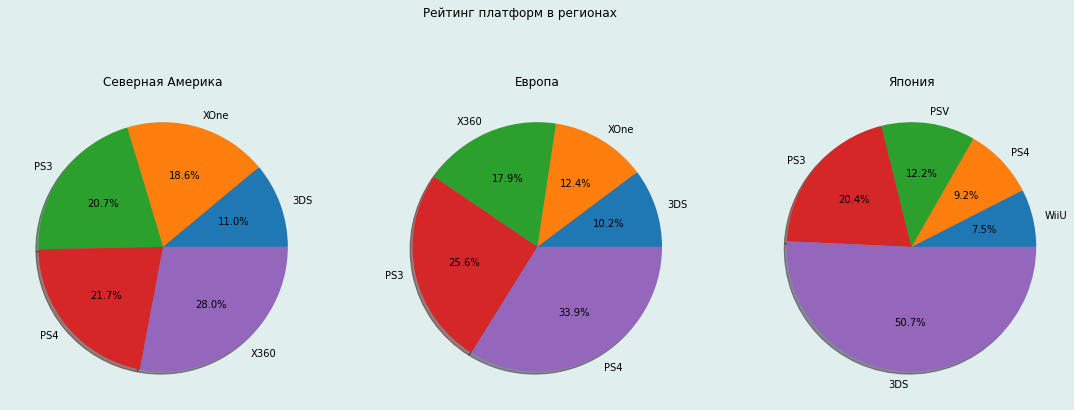

In [31]:
top_na = current_data.groupby('platform')['na_sales'].sum().sort_values().tail().reset_index()
top_eu = current_data.groupby('platform')['eu_sales'].sum().sort_values().tail().reset_index()
top_jp = current_data.groupby('platform')['jp_sales'].sum().sort_values().tail().reset_index()
fig, axs = plt.subplots(1, 3, figsize=(19, 7))
fig.set_facecolor('#E0EEEE')
axs[0].pie(top_na['na_sales'], labels = top_na['platform'], shadow = True, autopct = '%1.1f%%')
axs[0].set_title('Северная Америка')

axs[1].pie(top_eu['eu_sales'], labels = top_eu['platform'], shadow = True, autopct = '%1.1f%%')
axs[1].set_title('Европа')

axs[2].pie(top_jp['jp_sales'], labels = top_jp['platform'], shadow = True, autopct = '%1.1f%%')
axs[2].set_title('Япония')
plt.suptitle('Рейтинг платформ в регионах')

**В регионе NA и EU самыми популярными платформами являются PS и XBox. В JP регионе больше распространены консоли Нинтендо.**

**Определим рейтинг игровых жанров в каждом регионе.**

Text(0.5, 0.98, 'Рейтинг игровых жанров в регионах')

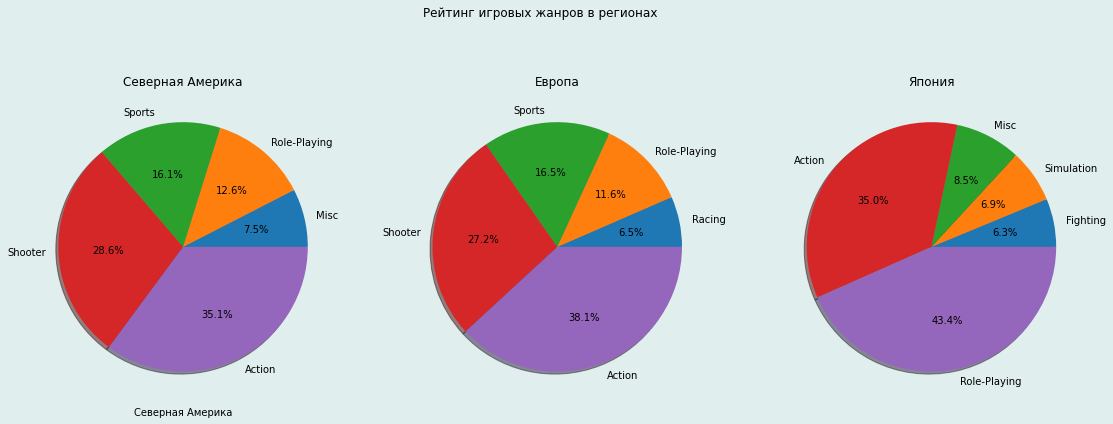

In [32]:
genre_na = current_data.groupby('genre')['na_sales'].sum().sort_values().tail().reset_index()
genre_eu = current_data.groupby('genre')['eu_sales'].sum().sort_values().tail().reset_index()
genre_jp = current_data.groupby('genre')['jp_sales'].sum().sort_values().tail().reset_index()
fig, axs = plt.subplots(1, 3, figsize=(19, 7))
fig.set_facecolor('#E0EEEE')
axs[0].pie(genre_na['na_sales'], labels = genre_na['genre'], shadow = True, autopct = '%1.1f%%')
axs[0].set_title('Северная Америка')
axs[0].set_xlabel('Северная Америка')
axs[1].pie(genre_eu['eu_sales'], labels = genre_eu['genre'], shadow = True, autopct = '%1.1f%%')
axs[1].set_title('Европа')

axs[2].pie(genre_jp['jp_sales'], labels = genre_jp['genre'], shadow = True, autopct = '%1.1f%%')
axs[2].set_title('Япония')
plt.suptitle('Рейтинг игровых жанров в регионах')

**Интересы Америки и Европы совпадают: явный перевес у жанров Action и Shooter. Азия не была бы азией без РПГ. Action и Shooter замыкают топ 3 игр.**

**Посмотрим как возрастной рейтинг влияет на продажи в регионах.**

Text(0.5, 1.0, 'Продажи игр в Северной Америке с сортировкой по возрастному рейтингу')

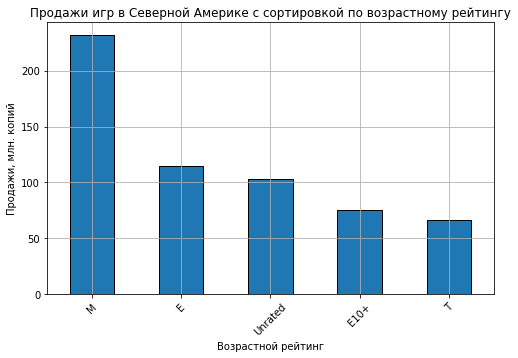

In [33]:
(
    current_data[current_data['na_sales'] > 0]
    .pivot_table(index=['rating'], 
                 values=['name', 'na_sales'], 
                 aggfunc={'name':'count', 'na_sales':'sum'})    
    .rename(columns={'name':'count_game'})
    .sort_values(by='na_sales', ascending=False)
    .reset_index()
    .plot(x='rating', y='na_sales', kind='bar', grid=True, figsize=(8,5), legend=False, edgecolor='black')
)
plt.xlabel('Возрастной рейтинг')
plt.xticks(rotation = 45)
plt.ylabel('Продажи, млн. копий')
plt.title('Продажи игр в Северной Америке с сортировкой по возрастному рейтингу')

Text(0.5, 1.0, 'Продажи игр в Европе с сортировкой по возрастному рейтингу')

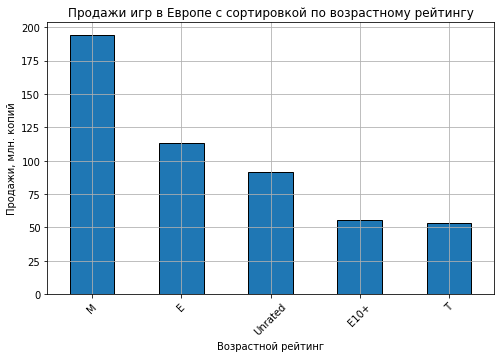

In [34]:
(
    current_data[current_data['eu_sales'] > 0]
    .pivot_table(index=['rating'], 
                 values=['name', 'eu_sales'], 
                 aggfunc={'name':'count', 'eu_sales':'sum'})                  
    .rename(columns={'name':'count_game'})
    .sort_values(by='eu_sales', ascending=False)
    .reset_index()
    .plot(x='rating', y='eu_sales', kind='bar', grid=True, figsize=(8,5), legend=False, edgecolor='black')
)
plt.xlabel('Возрастной рейтинг')
plt.xticks(rotation = 45)
plt.ylabel('Продажи, млн. копий')
plt.title('Продажи игр в Европе с сортировкой по возрастному рейтингу')

Text(0.5, 1.0, 'Продажи игр в Японии с сортировкой по возрастному рейтингу')

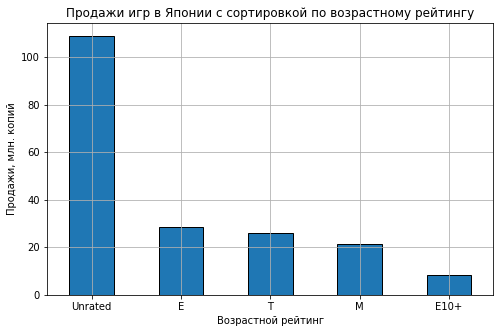

In [35]:
(
    current_data[current_data['jp_sales'] > 0]
    .pivot_table(index=['rating'], 
                 values=['name', 'jp_sales'], 
                 aggfunc={'name':'count', 'jp_sales':'sum'})                    
    .rename(columns={'name':'count_game'})
    .sort_values(by='jp_sales', ascending=False)
    .reset_index()
    .plot(x='rating', y='jp_sales', kind='bar', grid=True, figsize=(8,5), legend=False, edgecolor='black')
)
plt.xlabel('Возрастной рейтинг')
plt.xticks(rotation = 0)
plt.ylabel('Продажи, млн. копий')
plt.title('Продажи игр в Японии с сортировкой по возрастному рейтингу')

**В NA и EU регионе больше всего продаются игры с рейтингом "М", что значит "для взрослых", игры без ограничений по возрасту и игры, пришедшие из других регионов, неимеющие оценки североамериканской организации. В Японии ситуация обратная: Львиную долю занимают игры без рейтинга.**

## Шаг 5. Проверьте гипотезы

**H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
H1 - Средние пользовательские рейтинги платформ Xbox One и PC не равны.**

In [36]:
pl_x_one = current_data.loc[(current_data['platform'] == 'XOne') & (current_data['user_score'] >= 0), 'user_score']
pc = current_data.loc[(current_data['platform'] == 'PC') & (current_data['user_score'] >= 0), 'user_score']
results = st.ttest_ind(pl_x_one, pc, alternative='two-sided', equal_var = False)
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нулевую гипотезу не отвергаем.')

p-значение: 0.5489537965134912
Нулевую гипотезу не отвергаем.


**Не удалось отвегнуть нулевую гипотезу. С большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий.**

Средние пользовательские рейтинги жанров Action и Sports разные.
**H0 - Средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports.**
**H1 - Средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.**

In [37]:
action_mean_users_score = current_data.loc[(current_data['genre'] == 'Action')&(current_data['user_score']>=0), 'user_score']
sports_mean_users_score = current_data.loc[(current_data['genre'] == 'Sports')&(current_data['user_score']>=0), 'user_score']
results = st.ttest_ind(action_mean_users_score, sports_mean_users_score, alternative='two-sided', equal_var = False)
alpha = 0.05
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Нулевую гипотезу не отвергаем.')

p-значение: 5.989458066467418e-20
Отвергаем нулевую гипотезу.


**Нулевую гипотезу отвергаем. Получается, средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.**

## Общий вывод.

Цель работы: Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

1. Был загружен предлагаемый датасет, проведена первичная оценка данных:
 1. Посмотрели несколько строк для общего понимания;
 2. Просмотрена информация об этом датасете;
2. Проведена предобработка данных.
3. Провели исследовательский анализ данных:
 Посмотрели динамику количества выпускаемых игр. Это помогло выбрать период, наиболее подходящий для оценки ситуации на рынке компьютерных игр и прогноза на следующий год. Выбрали период - 5 лет: с 2012 по 2016 годы, т.к в это время рынок был стабилен, без резких скачков.
 Посмотрели продолжительность жизни разлицных платформ и установили, что в среднем платформы актуальны примерно 8 лет.
 Определили топ-10 прибыльных платформ и посмотрели динамику продаж у пяти лучших платформ. С 2012 года самыми популярными платформами среди пользователей были PS4, РS3, X360, 3DS и XOne.
 По совокупности фактов привлекательными для нас остаются только 3 платформы: PS4 и XOne для североамериканского и европейского регионов, а 3DS для Японии.
 Самыми продаваемыми жанрами являются Action, Shooter, RPG и Sports за счет значительного количества "хитов".
 Установили, что оценки пользователей и критиков практически не влияют на продажи.
4. Составлен портрет пользователя каждого региона:
 Североамериканский и европейские регионы очень похожи: Популярны одни и те же платформы - PS и Х (североамериканцы чаще выбирают Х, а европейцы - "Плойки"), предпочитают одни и те же жанры - Action и Shooter. Если игра имеет возрастное ограничение "М", продаж будет еще больше.
 Японцы же чаще выбирают консоли Нинтендо, чуть реже PS, а из игр больше предпочитают РПГ и реже Action.
 На это стоит обратить внимание при планировании рекламных компаний в следующем году.
5. Проверены гипотезы:
 1. Не удалось отвегнуть нулевую гипотезу, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
 2. Гипотезу: "Средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports" отвергли. Получается, средние пользовательские рейтинги жанра Action не равны средним пользовательским рейтингам жанра Sports.